In [20]:
import keras
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Embedding, regularizers
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.merge import Concatenate
from keras import optimizers
from keras import backend as K
from w2v import train_word2vec 
import pickle, datetime
import numpy as np
import difflib

# ------------------------------- Data Preprocessing -----------------------------------

### Phrase -> index

In [27]:
phr_to_ind = dict()

with open('../../Datasets/SST1_dataset/dictionary.txt') as f:
    for line in f:
        entry = line.split('|')
        phr_to_ind[entry[0]] = int(entry[1])

keys = phr_to_ind.keys();

print(len(phr_to_ind), phr_to_ind['Good'])

239232 14058


### Getting Index corresponding to sentences

In [28]:
# Without doing the below computation directly load the stored output
sentence_list = []
sentiment = []

with open('../../Datasets/SST1_dataset/SentenceWithCorrection.txt') as f:
    for line in f:
        sent = line[:-1]
        sentence_list.append(sent)
        sentiment.append(phr_to_ind[sent])

print(len(sentence_list))

11855


In [29]:
# sentence_list = []
# sentiment = []

# with open('../../Datasets/SST1_dataset/datasetSentences.txt') as f:
#     f.readline()
#     for line in f:
#         entry = line.split('\t')
#         sent = entry[1][:-1]
#         sent = sent.replace('-LRB-', '(')
#         sent = sent.replace('-RRB-', ')')
    
#         if sent in phr_to_ind.keys():
#             sentiment.append(phr_to_ind[sent])
#         else:
#             print('.', end="")
#             keys_subset = [k for k in keys if (k[0] == sent[0])]
#             key = difflib.get_close_matches(sent, keys_subset, n=1);
#             sent = key[0]
#             sentiment.append(phr_to_ind[sent])
            
#         sentence_list.append(sent)
        
# print(len(sentence_list))

# # Written the output in a file
# f = open('../../Datasets/SST1_dataset/SentenceWithCorrection.txt', 'w')
# for sent in sentence_list:
#     f.write(sent + '\n')
# f.close()

### Phrase Index -> Sentiment

In [30]:
ind_to_senti = dict()

with open('../../Datasets/SST1_dataset/sentiment_labels.txt') as f:
    f.readline()
    for line in f:
        entry = line.split('|')
        ind_to_senti[int(entry[0])] = float(entry[1])

print(len(ind_to_senti))

239232


### Loading train, test and valid split info

In [31]:
split_ind = []
with open('../../Datasets/SST1_dataset/datasetSplit.txt') as f:
    f.readline()
    for line in f:
        entry = line.split(',')
        split_ind.append(int(entry[1]))

print(len(split_ind))

for i in range(len(split_ind)):
    if split_ind[i] == 3:
        split_ind[i] = 1
        
N_train = split_ind.count(1)
N_test = split_ind.count(2)
N_valid = split_ind.count(3)
print (N_train, N_test, N_valid)

11855
9645 2210 0


### Assigning label to sentences

In [32]:
N_sent = len(sentence_list);
N_category = 5

y_label = []

for ind in sentiment:
    val = ind_to_senti[ind]
    if val >= 0.0 and val <= 0.2:
        y_label.append(0);
    elif val > 0.2 and val <= 0.4:
        y_label.append(1)
    elif val > 0.4 and val <= 0.6:
        y_label.append(2)
    elif val > 0.6 and val <= 0.8:
        y_label.append(3)
    else:
        y_label.append(4)

print(y_label.count(0), y_label.count(1), y_label.count(2), y_label.count(3))

# Labels in one-hot encoding
y_train = np.zeros((N_train, N_category), np.uint8)
y_test  = np.zeros((N_test , N_category), np.uint8)
y_valid = np.zeros((N_valid, N_category), np.uint8)

c1,c2,c3 = 0,0,0
for i in range(len(y_label)):
    label = y_label[i]
    if split_ind[i] == 1:
        y_train[c1, label] = 1;  c1 += 1
    elif split_ind[i] == 2:
        y_test [c2, label] = 1;  c2 += 1
    else:
        y_valid[c3, label] = 1;  c3 += 1

1510 3140 2242 3111


### Reducing the size of vocabulary

In [33]:
x_all = []
max_sent_len = -1;
max_wrd_len = -1
wrd_to_ind = dict()

ind_new = 1;
for sent in sentence_list:
    wrds = sent.split()
    vec = []
    for wrd in wrds:
        if wrd not in wrd_to_ind.keys():
            wrd_to_ind[wrd] = ind_new
            ind_new += 1
            
        ind = wrd_to_ind[wrd]
        vec.append(ind)
            
    max_sent_len = max(len(vec), max_sent_len)
    x_all.append(vec)

# Get inverse dictionary
ind_to_wrd = dict((v, k) for k, v in wrd_to_ind.items())
ind_to_wrd[0] = "<PAD/>"

print(len(phr_to_ind), len(wrd_to_ind))

239232 21699


### Create input features

In [34]:
x_train = np.zeros((N_train, max_sent_len), np.int32)
x_test  = np.zeros((N_test,  max_sent_len), np.int32)
x_valid = np.zeros((N_valid, max_sent_len), np.int32)

c1, c2, c3 = 0,0,0
for i in range(len(x_all)):
    vec = x_all[i]
    if split_ind[i] == 1:
        x_train[c1,0:len(vec)] = np.int32(vec); 
        c1 += 1
    elif split_ind[i] == 2:
        x_test [c2,0:len(vec)] = np.int32(vec); 
        c2 += 1
    else:
        x_valid[c3,0:len(vec)] = np.int32(vec); 
        c3 += 1

print(c1, c2, c3)

9645 2210 0


# -------------------------------- Training model  -----------------------------------

### Model Paremeters

In [35]:
model_type    = 'CNN-rand'  # CNN-rand|CNN-non-static|CNN-static
embedding_dim = 300         # word2vec dim
vocab_size    = len(ind_to_wrd)

### Generate word2vec 

In [36]:
if model_type in ['CNN-non-static', 'CNN-static']:
    embedding_wts = train_word2vec( np.vstack((x_train, x_test, x_valid)), 
                                    ind_to_wrd, num_features = embedding_dim)
    if model_type == 'CNN-static':
        x_train = embedding_wts[0][x_train]
        x_test  = embedding_wts[0][x_test]
        x_valid = embedding_wts[0][x_valid]
        
elif model_type == 'CNN-rand':
    embedding_wts = None
    
else:
    raise ValueError("Unknown model type")

### Create model

In [37]:
batch_size   = 50
filter_sizes = [3,4,5]
num_filters  = 100
dropout_prob = (0.5, 0.8)
hidden_dims  = 100

l2_reg = 0.3
embedding_dim = 300

# Deciding dimension of input based on the model
input_shape = (max_sent_len, embedding_dim) if model_type == "CNN-static" else (max_sent_len,)
model_input = Input(shape = input_shape)

# Static model do not have embedding layer
if model_type == "CNN-static":
    z = Dropout(dropout_prob[0])(model_input)
else:
    z = Embedding(vocab_size, embedding_dim, input_length = max_sent_len, name="embedding")(model_input)
    z = Dropout(dropout_prob[0])(z)

# Convolution layers
z1 = Conv1D(    filters=100, kernel_size=3, 
                padding="valid", activation="relu", 
                strides=1)(z)
z1 = MaxPooling1D(pool_size=2)(z1)
z1 = Flatten()(z1)

z2 = Conv1D(    filters=100, kernel_size=4, 
                padding="valid", activation="relu", 
                strides=1)(z)
z2 = MaxPooling1D(pool_size=2)(z2)
z2 = Flatten()(z2)

z3 = Conv1D(    filters=100, kernel_size=5, 
                padding="valid", activation="relu",
                strides=1)(z)
z3 = MaxPooling1D(pool_size=2)(z3)
z3 = Flatten()(z3)

# Concatenate the output of all convolution layers
z = Concatenate()([z1, z2, z3])
z = Dropout(dropout_prob[1])(z)

# Dense(64, input_dim=64, kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.01))

z = Dense(hidden_dims, activation="relu", kernel_regularizer=regularizers.l2(0.01))(z)
model_output = Dense(N_category, activation="sigmoid")(z)
    
model = Model(model_input, model_output)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adadelta(lr=1, decay=0.001), metrics=["accuracy"])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 56)            0                                            
____________________________________________________________________________________________________
embedding (Embedding)            (None, 56, 300)       6510000                                      
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 56, 300)       0                                            
____________________________________________________________________________________________________
conv1d_4 (Conv1D)                (None, 54, 100)       90100                                        
___________________________________________________________________________________________

### Train model 

In [15]:
if model_type == "CNN-non-static":
    embedding_layer = model.get_layer("embedding")
    embedding_layer.set_weights(embedding_wts)

res = model.fit(x_train, y_train, 
          batch_size = batch_size,
          epochs=100,
          validation_data=(x_test, y_test), verbose=2)

Train on 8544 samples, validate on 1101 samples
Epoch 1/100
32s - loss: 1.9798 - acc: 0.2623 - val_loss: 1.6068 - val_acc: 0.2534
Epoch 2/100
29s - loss: 1.5861 - acc: 0.2656 - val_loss: 1.5814 - val_acc: 0.2534
Epoch 3/100
29s - loss: 1.5775 - acc: 0.2667 - val_loss: 1.5816 - val_acc: 0.2534
Epoch 4/100
29s - loss: 1.5757 - acc: 0.2710 - val_loss: 1.5784 - val_acc: 0.2534
Epoch 5/100
29s - loss: 1.5740 - acc: 0.2681 - val_loss: 1.5773 - val_acc: 0.2534
Epoch 6/100
29s - loss: 1.5730 - acc: 0.2717 - val_loss: 1.5776 - val_acc: 0.2534
Epoch 7/100
29s - loss: 1.5737 - acc: 0.2711 - val_loss: 1.5775 - val_acc: 0.2534
Epoch 8/100
29s - loss: 1.5719 - acc: 0.2725 - val_loss: 1.5764 - val_acc: 0.2534
Epoch 9/100
29s - loss: 1.5717 - acc: 0.2717 - val_loss: 1.5756 - val_acc: 0.2534
Epoch 10/100
29s - loss: 1.5715 - acc: 0.2708 - val_loss: 1.5764 - val_acc: 0.2534
Epoch 11/100
29s - loss: 1.5709 - acc: 0.2719 - val_loss: 1.5761 - val_acc: 0.2534
Epoch 12/100
29s - loss: 1.5701 - acc: 0.2721 - 

### Computing Accuracy

In [46]:
# Training Accuracy
predictions = model.predict(x_train)
pred_train = np.argmax(predictions, axis=1)
train_label = np.argmax(y_train, axis=1)
print('Training Accuracy', np.sum(pred_train == train_label) / N_train * 100)

# # Training Accuracy
# predictions = model.predict(x_valid)
# pred_valid = np.argmax(predictions, axis=1)
# valid_label = np.argmax(y_valid, axis=1)
# print('Validation Accuracy', np.sum(pred_valid == valid_label) / N_valid * 100)

# Test Accuracy
predictions = model.predict(x_test)
pred_test = np.argmax(predictions, axis=1)
test_label = np.argmax(y_test, axis=1)
print('Testing Accuracy', np.sum(pred_test == test_label) / N_test * 100)

Training Accuracy 67.579056506
Testing Accuracy 39.9095022624


In [43]:
date = str(datetime.date.today() )
time = str(datetime.datetime.now().time())[:-7]

filename = '/home/shikhar/Datasets/Models/' + model_type + '_' + date + '_' +time;
with open( filename, 'wb') as output:
    pickle.dump([res.model.get_config(), res.model.get_weights(), res.history], output, pickle.HIGHEST_PROTOCOL)
    
## Loading saved data
# with open( filename, 'rb') as input:
#     out = pickle.load(input)

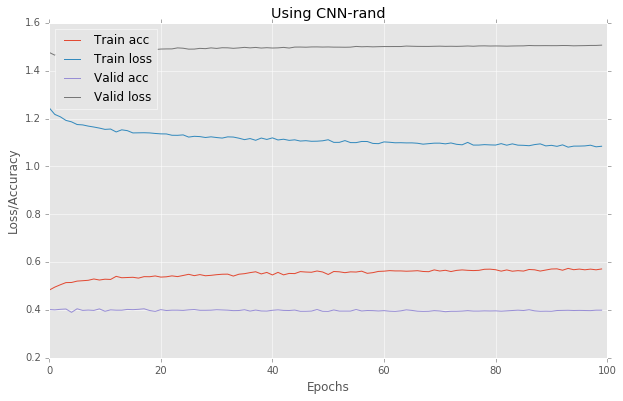

In [44]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.rcParams["figure.figsize"] = (10,6)
plt.plot(res.history['acc'])
plt.plot(res.history['loss'])
plt.plot(res.history['val_acc'])
plt.plot(res.history['val_loss'])
plt.legend(['Train acc','Train loss','Valid acc', 'Valid loss'], loc=2)
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.title('Using '+ model_type)
imgName = 'Images/' + model_type + '_' + date + '_' + time + '.jpg'
plt.savefig( imgName, dpi= 200, bbox_inches='tight', transparent=False)
plt.show()

### Continue from a pretrained model

In [39]:
# Loading saved data
import pickle

# filename = '/home/shikhar/Datasets/Models/CNN-rand_continued_2017-04-02_07:34:54'
with open( filename, 'rb') as input:
    out = pickle.load(input)

model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adadelta(lr=.5, decay=0.005), metrics=["accuracy"])
model.set_weights(out[1])

res = model.fit(x_train, y_train, 
          batch_size = batch_size,
          epochs=100,
          validation_data=(x_test, y_test), verbose=2)

Train on 9645 samples, validate on 2210 samples
Epoch 1/100
35s - loss: 1.3078 - acc: 0.4572 - val_loss: 1.4622 - val_acc: 0.3878
Epoch 2/100
36s - loss: 1.2892 - acc: 0.4649 - val_loss: 1.4579 - val_acc: 0.4032
Epoch 3/100
34s - loss: 1.2742 - acc: 0.4732 - val_loss: 1.4617 - val_acc: 0.4027
Epoch 4/100
33s - loss: 1.2765 - acc: 0.4754 - val_loss: 1.4688 - val_acc: 0.4032
Epoch 5/100
33s - loss: 1.2716 - acc: 0.4773 - val_loss: 1.4616 - val_acc: 0.4027
Epoch 6/100
33s - loss: 1.2652 - acc: 0.4765 - val_loss: 1.4660 - val_acc: 0.4023
Epoch 7/100
34s - loss: 1.2560 - acc: 0.4826 - val_loss: 1.4620 - val_acc: 0.4018
Epoch 8/100
33s - loss: 1.2566 - acc: 0.4788 - val_loss: 1.4582 - val_acc: 0.4018
Epoch 9/100
33s - loss: 1.2570 - acc: 0.4807 - val_loss: 1.4612 - val_acc: 0.4027
Epoch 10/100
33s - loss: 1.2495 - acc: 0.4841 - val_loss: 1.4607 - val_acc: 0.3991
Epoch 11/100
33s - loss: 1.2464 - acc: 0.4891 - val_loss: 1.4593 - val_acc: 0.4036
Epoch 12/100
33s - loss: 1.2443 - acc: 0.4942 - 

In [47]:
date = str(datetime.date.today() )
time = str(datetime.datetime.now().time())[:-7]

filename = '/home/shikhar/Datasets/Models/' + model_type + '_continued_' + date + '_' +time;
with open( filename, 'wb') as output:
    pickle.dump([model.get_config(), model.get_weights(), model.history.history], output, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Loading saved data
import pickle

# filename = '/home/shikhar/Datasets/Models/CNN-rand_continued_2017-04-02_07:34:54'
with open( filename, 'rb') as input:
    out = pickle.load(input)

model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(), metrics=["accuracy"])
model.set_weights(out[1])

res = model.fit(x_train, y_train, 
          batch_size = batch_size,
          epochs=50,
          validation_data=(x_test, y_test), verbose=2)

Train on 9645 samples, validate on 2210 samples
Epoch 1/50
29s - loss: 1.2987 - acc: 0.5014 - val_loss: 1.5091 - val_acc: 0.4100
Epoch 2/50
27s - loss: 1.1156 - acc: 0.5962 - val_loss: 1.6418 - val_acc: 0.3842
Epoch 3/50
29s - loss: 0.9404 - acc: 0.6837 - val_loss: 1.8923 - val_acc: 0.3814
Epoch 4/50
27s - loss: 0.7824 - acc: 0.7579 - val_loss: 2.1546 - val_acc: 0.3710
Epoch 5/50
27s - loss: 0.6796 - acc: 0.8083 - val_loss: 2.3504 - val_acc: 0.3787
Epoch 6/50
27s - loss: 0.5658 - acc: 0.8540 - val_loss: 2.6239 - val_acc: 0.3697
Epoch 7/50
27s - loss: 0.5065 - acc: 0.8782 - val_loss: 2.8259 - val_acc: 0.3620
Epoch 8/50
28s - loss: 0.4497 - acc: 0.8980 - val_loss: 3.0957 - val_acc: 0.3760
Epoch 9/50
30s - loss: 0.4030 - acc: 0.9157 - val_loss: 3.2679 - val_acc: 0.3575
Epoch 10/50
27s - loss: 0.3794 - acc: 0.9259 - val_loss: 3.4511 - val_acc: 0.3602
Epoch 11/50
28s - loss: 0.3592 - acc: 0.9279 - val_loss: 3.4120 - val_acc: 0.3652
Epoch 12/50
28s - loss: 0.3331 - acc: 0.9337 - val_loss: 3.

In [ ]:
import os
os.system('say done')